In [1]:
! pip -q install --no-dependencies equinox jaxtyping

In [2]:
! pip -q install optax

In [3]:
! git init .
! git remote add origin https://github.com/VLSF/SDC
! git pull origin main

Reinitialized existing Git repository in /content/.git/
fatal: remote origin already exists.
From https://github.com/VLSF/SDC
 * branch            main       -> FETCH_HEAD
Already up to date.


In [4]:
import jax.numpy as jnp
from jax import config, random, jit, vmap, grad

import equinox as eqx
import optax

from architectures import ChebNO
from datasets import generate_dataset, metrics
from misc import equations

from integrators import RK4, Explicit_Euler, Implicit_Euler
from sdc_integrators import RK4 as RK4_c, Explicit_Euler as Explicit_Euler_c, Implicit_Euler as Implicit_Euler_c

config.update("jax_enable_x64", True)

import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'

In [5]:
def batch_generator(train_data, key, chunk_size):
    train_features, train_targets = train_data
    n = random.permutation(key, jnp.arange(train_features.shape[0], dtype=int))
    train_features, train_targets = train_features[n], train_targets[n]
    chunks = [*range(0, train_features.shape[0] + 1, chunk_size)]
    if chunks[-1] < train_features.shape[0]:
        chunks.append(train_features.shape[0])
    for i, j in zip(chunks[:-1], chunks[1:]):
        yield train_features[i:j], train_targets[i:j]

# Generate dataset

Solve ODE

In [6]:
ODE_data = equations.get_ODE("Lorenz")
integrator = "RK4"
P_u0 = lambda key: random.normal(key, (3,))
key = random.PRNGKey(13)
N_points = 40
T_max = 1
N_intervals = 2
N_SDC = 20
N_samples = 1000

dataset, T = generate_dataset.concoct_regular_dataset(ODE_data, integrator, P_u0, T_max, N_points, N_intervals, N_SDC, N_samples, key)

Check residuals

In [7]:
# computing residual for the last SDC iteration
R = generate_dataset.get_residual(dataset, ODE_data, T_max, N_intervals)
print("shape of computed residual", R.shape)
print(jnp.mean(R))

shape of computed residual (1000, 2)
2.345958413065942e-13


Prepare features and targers.

In [8]:
dataset.shape

(1000, 2, 20, 3, 40)

In [9]:
features0 = dataset[:, :, :1, :, :]
targets0 = dataset[:, :, -1, :, :]

feature0_train = features0[:800, :, :, :, :].reshape(800*N_intervals, features0.shape[2]*features0.shape[3], -1)
targets0_train = targets0[:800, :, :, :].reshape(800*N_intervals, targets0.shape[2], -1)

feature0_test = features0[800:, :, :, :, :].reshape(200*N_intervals, features0.shape[2]*features0.shape[3], -1)
targets0_test = targets0[800:, :, :, :].reshape(200*N_intervals, targets0.shape[2], -1)

In [10]:
feature0_train.shape, targets0_train.shape

((1600, 3, 40), (1600, 3, 40))

In [11]:
feature0_test.shape, targets0_test.shape

((400, 3, 40), (400, 3, 40))

In [12]:
features2 = dataset[:, :, :3, :, :]
targets2 = dataset[:, :, -1, :, :]

feature2_train = features2[:800, :, :, :, :].reshape(800*N_intervals, features2.shape[2]*features2.shape[3], -1)
targets2_train = targets2[:800, :, :, :].reshape(800*N_intervals, targets2.shape[2], -1)

feature2_test = features2[800:, :, :, :, :].reshape(200*N_intervals, features2.shape[2]*features2.shape[3], -1)
targets2_test = targets2[800:, :, :, :].reshape(200*N_intervals, targets2.shape[2], -1)

In [13]:
feature2_train.shape, targets2_train.shape

((1600, 9, 40), (1600, 3, 40))

In [14]:
feature2_test.shape, targets2_test.shape

((400, 9, 40), (400, 3, 40))

# Create and train a model

## Features = initial conditions

### Without truncation

In [15]:
key = random.PRNGKey(23)

N_features = [feature0_train.shape[1], 64, targets0_train.shape[1]]
N_layers = 5
kernel_size = 5
N_conv = 3
N_modes = feature0_train.shape[2]
model0 = ChebNO.ChebNO(N_features, N_layers, kernel_size, N_conv, N_modes, key)

In [16]:
learning_rate = 1e-3
weight_decay = 1e-2
N_batch = 40
N_epoch_decay = 70
N_epoch = 500
sc = optax.exponential_decay(learning_rate, int(feature0_train.shape[0] / N_batch) * N_epoch_decay, 0.75)
optim = optax.adamw(sc, weight_decay=weight_decay)

opt_state = optim.init(eqx.filter(model0, eqx.is_array))

In [17]:
ChebNO.make_step(model0, feature0_train[:N_batch], targets0_train[:N_batch], optim, opt_state);

In [18]:
%timeit ChebNO.make_step(model0, feature0_train[:N_batch], targets0_train[:N_batch], optim, opt_state);

20.8 ms ± 1.24 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [19]:
22 * 1e-3 * (feature0_train.shape[0] / N_batch) * N_epoch / 60

7.333333333333332

In [20]:
%timeit ChebNO.compute_loss(model0, feature0_train, targets0_train);

211 ms ± 18.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [21]:
e_train = []
e_test = []

key = random.PRNGKey(11)
for i in range(N_epoch):
    key = random.split(key)[0]
    ds = batch_generator([feature0_train, targets0_train], key, N_batch)
    for feature, target in ds:
        loss, model0, opt_state = ChebNO.make_step(model0, feature, target, optim, opt_state)
    e_train.append(ChebNO.compute_loss(model0, feature0_train, targets0_train).item())
    e_test.append(ChebNO.compute_loss(model0, feature0_test, targets0_test).item())

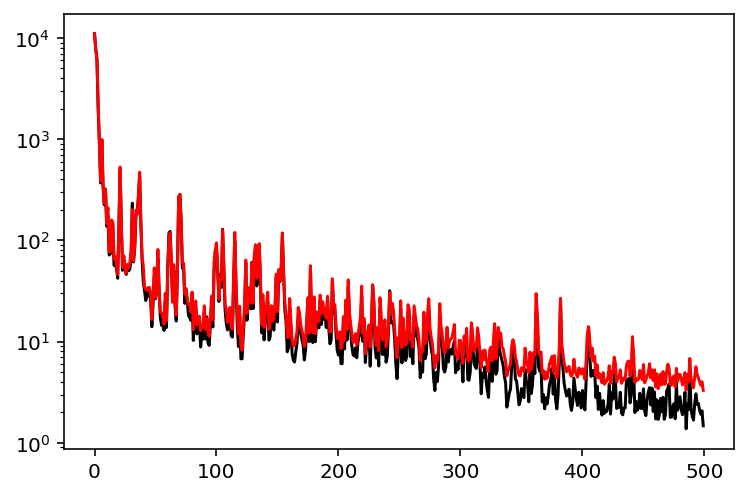

In [22]:
plt.yscale("log")
plt.plot(e_train, color="black")
plt.plot(e_test, color="red");

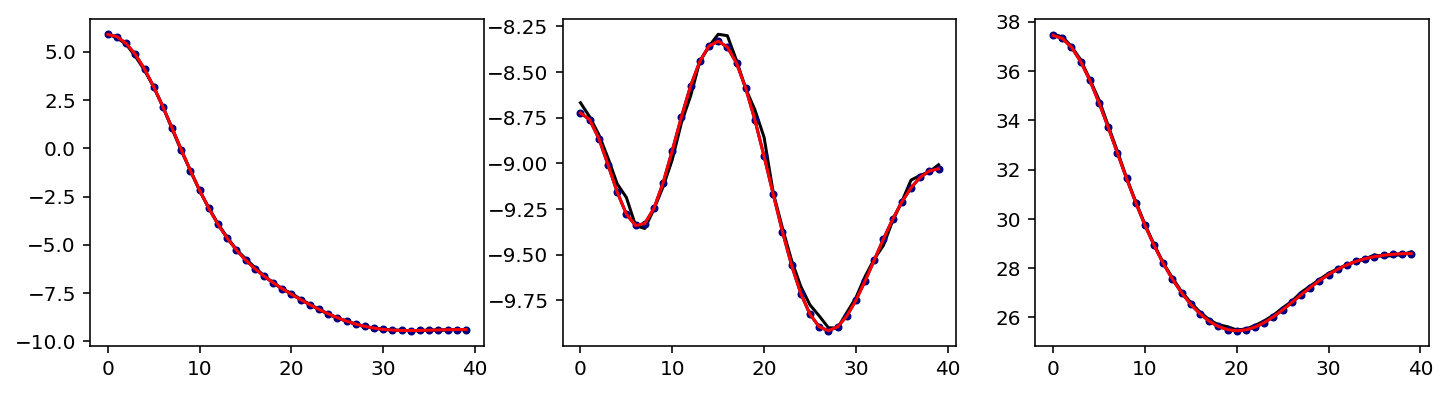

In [23]:
sample = 25
prediction = model0(feature0_train[sample])

fig, ax = plt.subplots(1, 3, figsize=(12, 3))
for k in range(feature0_train[sample].shape[0]):
    ax[k].plot(prediction[k], color="black")
    ax[k].plot(feature2_train[sample].reshape(3, 3, -1)[1, k, :], ".-", color="navy")
    ax[k].plot(targets0_train[sample][k], color="red");

In [24]:
sample = 25
prediction = model0(feature0_train[sample])

Errors_RK4 = [jnp.linalg.norm(feature2_train[sample].reshape(3, 3, -1)[1, k, :] - targets0_train[sample][k]) for k in range(3)]
Errors_NO = [jnp.linalg.norm(prediction[k, :] - targets0_train[sample][k]) for k in range(3)]

print([e.item() for e in Errors_RK4])
print([e.item() for e in Errors_NO])

[0.0001940100963974609, 0.0002788058601150325, 0.0003893241841160863]
[0.21481098449749333, 0.23878087540193899, 0.3795503848075284]


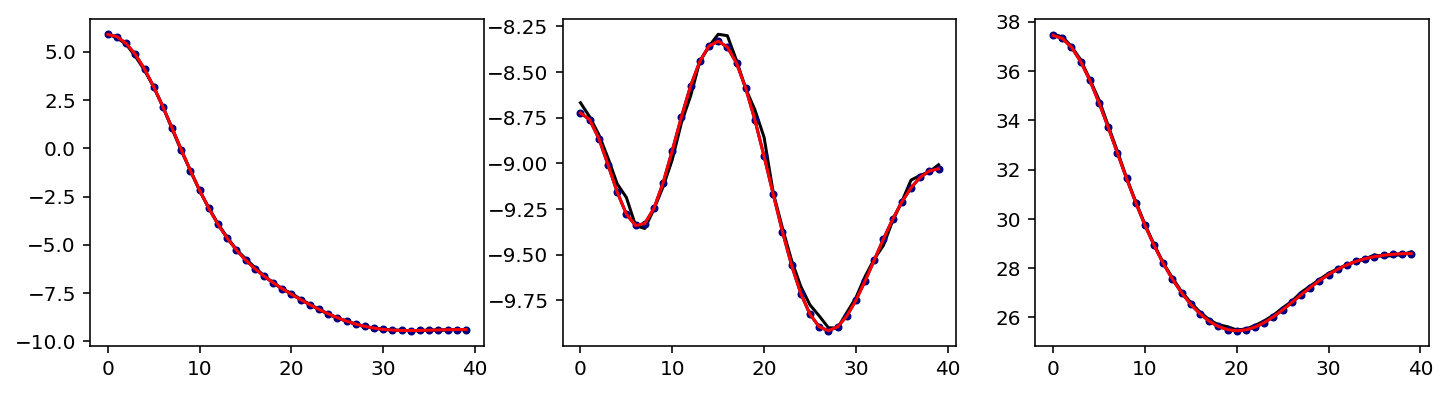

In [25]:
sample = 25
prediction = model0(feature0_train[sample])

fig, ax = plt.subplots(1, 3, figsize=(12, 3))
for k in range(feature0_train[sample].shape[0]):
    ax[k].plot(prediction[k], color="black")
    ax[k].plot(feature2_train[sample].reshape(3, 3, -1)[1, k, :], ".-", color="navy")
    ax[k].plot(targets0_train[sample][k], color="red");

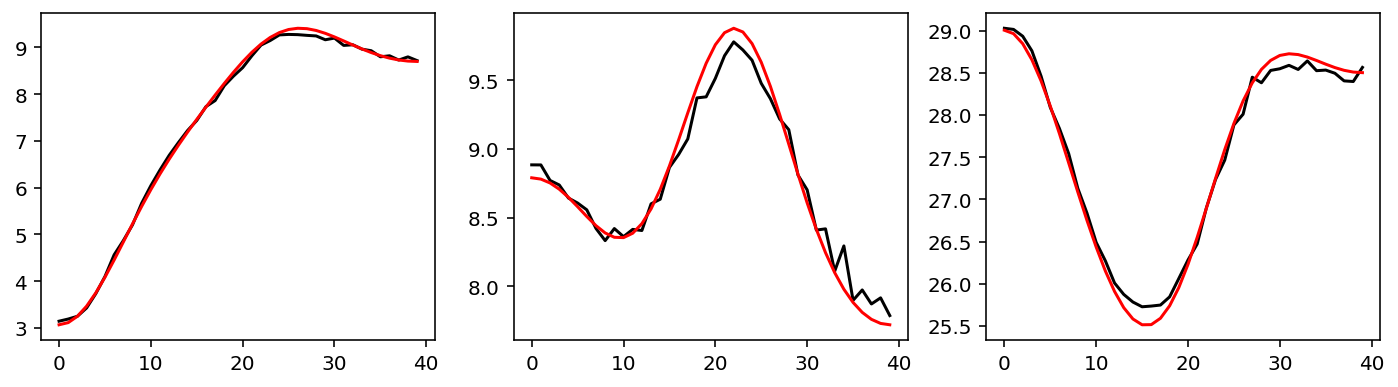

In [26]:
sample = 25
prediction = model0(feature0_test[sample])

fig, ax = plt.subplots(1, 3, figsize=(12, 3))
for k in range(feature0_test[sample].shape[0]):
    ax[k].plot(prediction[k], color="black")
    ax[k].plot(targets0_test[sample][k], color="red");

### With truncation

In [29]:
key = random.PRNGKey(23)

N_features = [feature0_train.shape[1], 64, targets0_train.shape[1]]
N_layers = 5
kernel_size = 5
N_conv = 3
N_modes = 10
model0 = ChebNO.ChebNO(N_features, N_layers, kernel_size, N_conv, N_modes, key)

In [30]:
learning_rate = 1e-3
weight_decay = 1e-2
N_batch = 40
N_epoch_decay = 70
N_epoch = 500
sc = optax.exponential_decay(learning_rate, int(feature0_train.shape[0] / N_batch) * N_epoch_decay, 0.75)
optim = optax.adamw(sc, weight_decay=weight_decay)

opt_state = optim.init(eqx.filter(model0, eqx.is_array))

In [31]:
ChebNO.make_step(model0, feature0_train[:N_batch], targets0_train[:N_batch], optim, opt_state);

In [32]:
%timeit ChebNO.make_step(model0, feature0_train[:N_batch], targets0_train[:N_batch], optim, opt_state);

12.7 ms ± 333 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [33]:
22 * 1e-3 * (feature0_train.shape[0] / N_batch) * N_epoch / 60

7.333333333333332

In [34]:
%timeit ChebNO.compute_loss(model0, feature0_train, targets0_train);

126 ms ± 1.54 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [35]:
e_train = []
e_test = []

key = random.PRNGKey(11)
for i in range(N_epoch):
    key = random.split(key)[0]
    ds = batch_generator([feature0_train, targets0_train], key, N_batch)
    for feature, target in ds:
        loss, model0, opt_state = ChebNO.make_step(model0, feature, target, optim, opt_state)
    e_train.append(ChebNO.compute_loss(model0, feature0_train, targets0_train).item())
    e_test.append(ChebNO.compute_loss(model0, feature0_test, targets0_test).item())

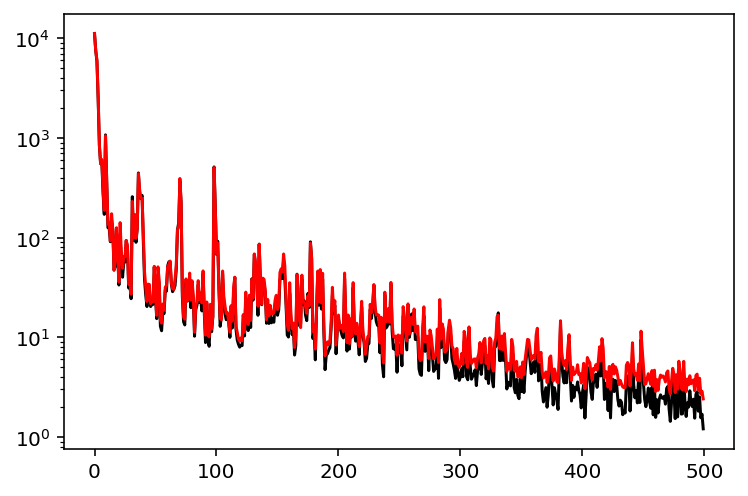

In [36]:
plt.yscale("log")
plt.plot(e_train, color="black")
plt.plot(e_test, color="red");

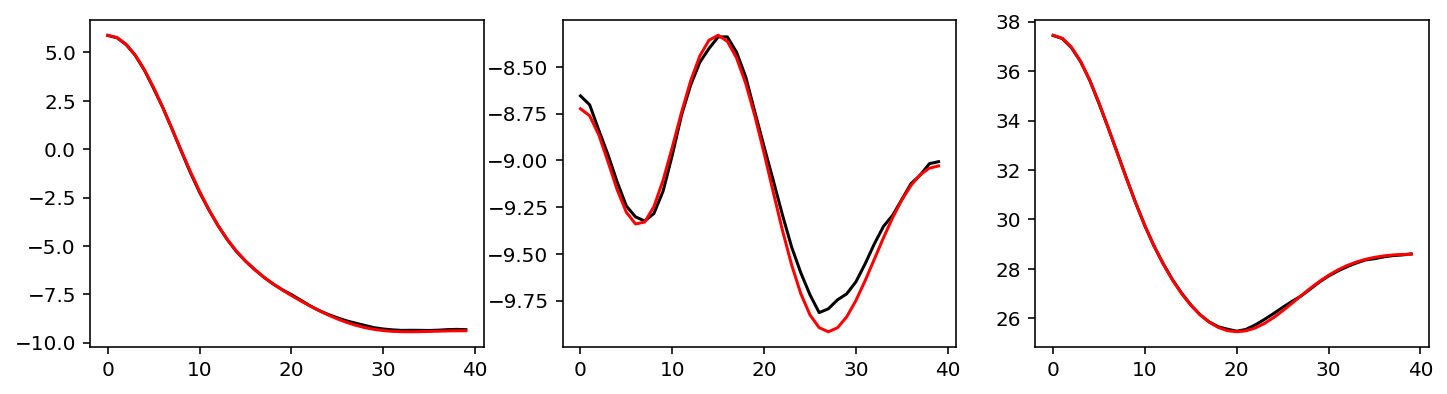

In [37]:
sample = 25
prediction = model0(feature0_train[sample])

fig, ax = plt.subplots(1, 3, figsize=(12, 3))
for k in range(feature0_train[sample].shape[0]):
    ax[k].plot(prediction[k], color="black")
    ax[k].plot(targets0_train[sample][k], color="red");

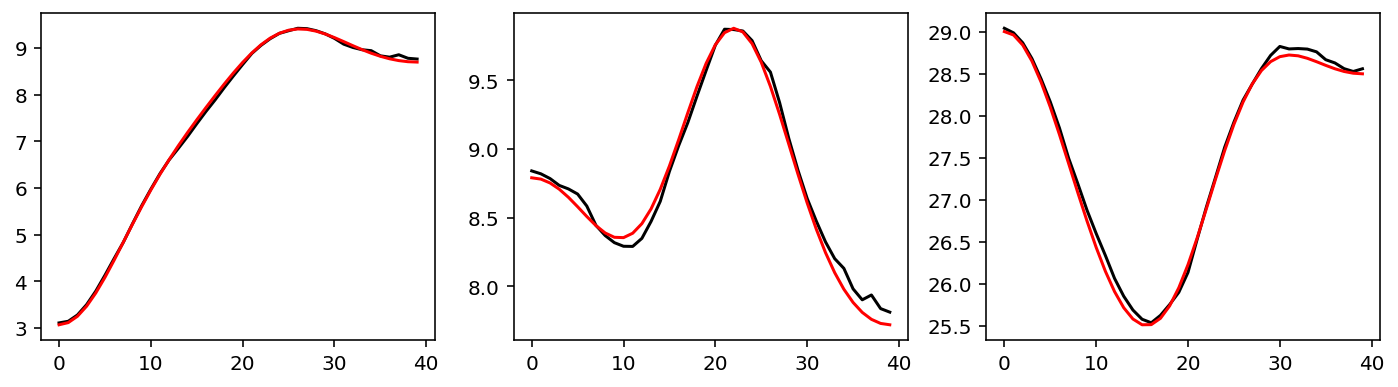

In [38]:
sample = 25
prediction = model0(feature0_test[sample])

fig, ax = plt.subplots(1, 3, figsize=(12, 3))
for k in range(feature0_test[sample].shape[0]):
    ax[k].plot(prediction[k], color="black")
    ax[k].plot(targets0_test[sample][k], color="red");

### With truncation and spatial convolutions

In [39]:
key = random.PRNGKey(23)

N_features = [feature0_train.shape[1], 64, targets0_train.shape[1]]
N_layers = 5
kernel_size = 5
spatial_kernel_size = 5
N_conv = 3
N_modes = 10
model0 = ChebNO.ChebNO(N_features, N_layers, kernel_size, N_conv, N_modes, key, spatial_kernel_size=spatial_kernel_size)

In [40]:
learning_rate = 1e-3
weight_decay = 1e-2
N_batch = 40
N_epoch_decay = 70
N_epoch = 500
sc = optax.exponential_decay(learning_rate, int(feature0_train.shape[0] / N_batch) * N_epoch_decay, 0.75)
optim = optax.adamw(sc, weight_decay=weight_decay)

opt_state = optim.init(eqx.filter(model0, eqx.is_array))

In [41]:
ChebNO.make_step(model0, feature0_train[:N_batch], targets0_train[:N_batch], optim, opt_state);

In [42]:
%timeit ChebNO.make_step(model0, feature0_train[:N_batch], targets0_train[:N_batch], optim, opt_state);

15.6 ms ± 368 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [43]:
22 * 1e-3 * (feature0_train.shape[0] / N_batch) * N_epoch / 60

7.333333333333332

In [44]:
%timeit ChebNO.compute_loss(model0, feature0_train, targets0_train);

153 ms ± 334 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [45]:
e_train = []
e_test = []

key = random.PRNGKey(11)
for i in range(N_epoch):
    key = random.split(key)[0]
    ds = batch_generator([feature0_train, targets0_train], key, N_batch)
    for feature, target in ds:
        loss, model0, opt_state = ChebNO.make_step(model0, feature, target, optim, opt_state)
    e_train.append(ChebNO.compute_loss(model0, feature0_train, targets0_train).item())
    e_test.append(ChebNO.compute_loss(model0, feature0_test, targets0_test).item())

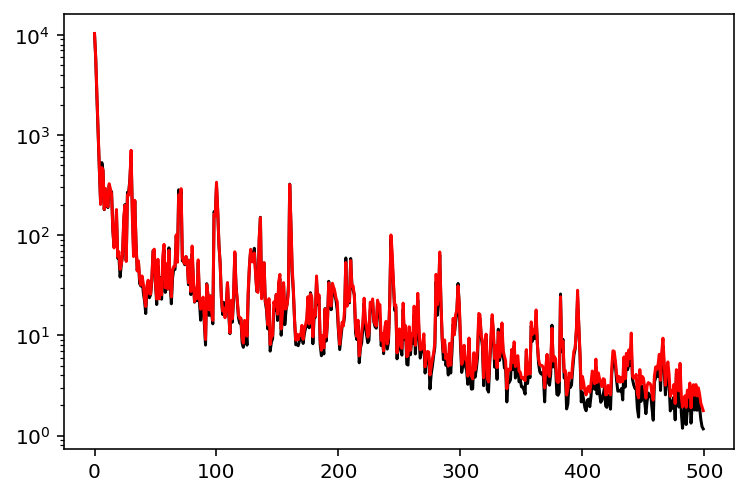

In [46]:
plt.yscale("log")
plt.plot(e_train, color="black")
plt.plot(e_test, color="red");

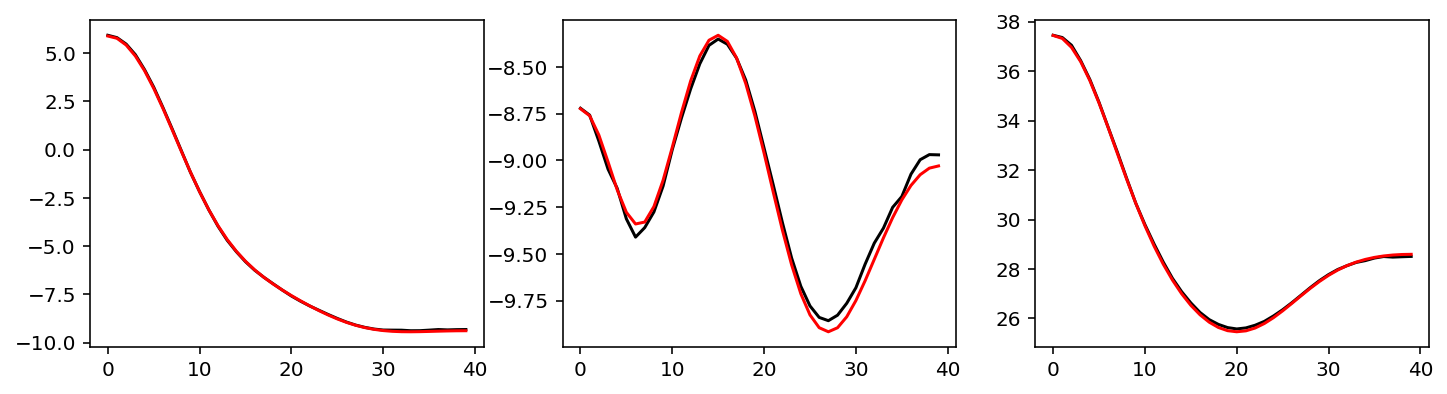

In [47]:
sample = 25
prediction = model0(feature0_train[sample])

fig, ax = plt.subplots(1, 3, figsize=(12, 3))
for k in range(feature0_train[sample].shape[0]):
    ax[k].plot(prediction[k], color="black")
    ax[k].plot(targets0_train[sample][k], color="red");

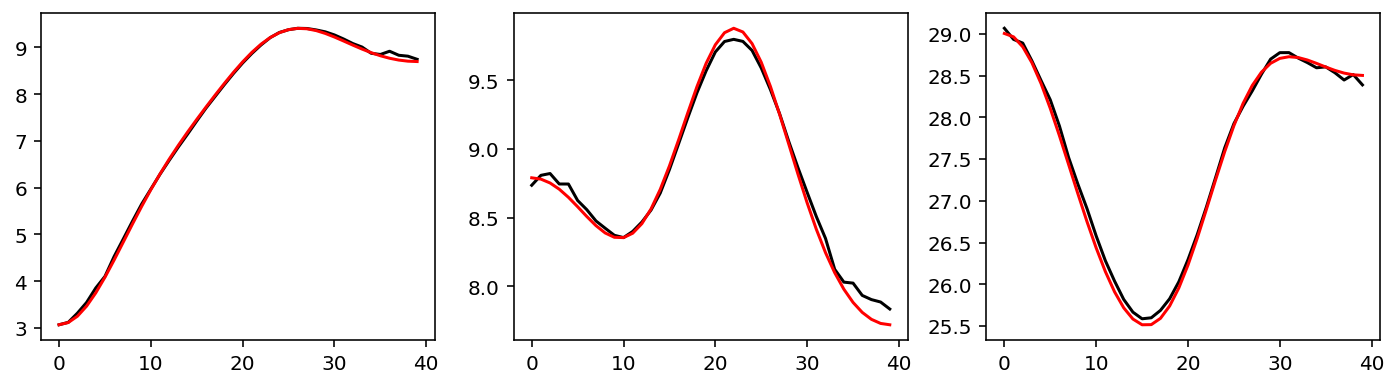

In [48]:
sample = 25
prediction = model0(feature0_test[sample])

fig, ax = plt.subplots(1, 3, figsize=(12, 3))
for k in range(feature0_test[sample].shape[0]):
    ax[k].plot(prediction[k], color="black")
    ax[k].plot(targets0_test[sample][k], color="red");

## Reach features

### Without truncation

In [49]:
key = random.PRNGKey(23)

N_features = [feature2_train.shape[1], 64, targets2_train.shape[1]]
N_layers = 5
kernel_size = 5
N_conv = 3
N_modes = feature0_train.shape[2]
model2 = ChebNO.ChebNO(N_features, N_layers, kernel_size, N_conv, N_modes, key)

In [50]:
learning_rate = 1e-3
weight_decay = 1e-2
N_batch = 40
N_epoch_decay = 70
N_epoch = 500
sc = optax.exponential_decay(learning_rate, int(feature2_train.shape[0] / N_batch) * N_epoch_decay, 0.5)
optim = optax.adamw(sc, weight_decay=weight_decay)

opt_state = optim.init(eqx.filter(model2, eqx.is_array))

In [51]:
ChebNO.make_step(model2, feature2_train[:N_batch], targets2_train[:N_batch], optim, opt_state);

In [52]:
%timeit ChebNO.make_step(model2, feature2_train[:N_batch], targets2_train[:N_batch], optim, opt_state);

21.3 ms ± 283 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [53]:
22 * 1e-3 * (feature2_train.shape[0] / N_batch) * N_epoch / 60

7.333333333333332

In [54]:
%timeit ChebNO.compute_loss(model2, feature2_train, targets2_train);

214 ms ± 771 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [55]:
e_train = []
e_test = []

key = random.PRNGKey(11)
for i in range(N_epoch):
    key = random.split(key)[0]
    ds = batch_generator([feature2_train, targets2_train], key, N_batch)
    for feature, target in ds:
        loss, model2, opt_state = ChebNO.make_step(model2, feature, target, optim, opt_state)
    e_train.append(ChebNO.compute_loss(model2, feature2_train, targets2_train).item())
    e_test.append(ChebNO.compute_loss(model2, feature2_test, targets2_test).item())

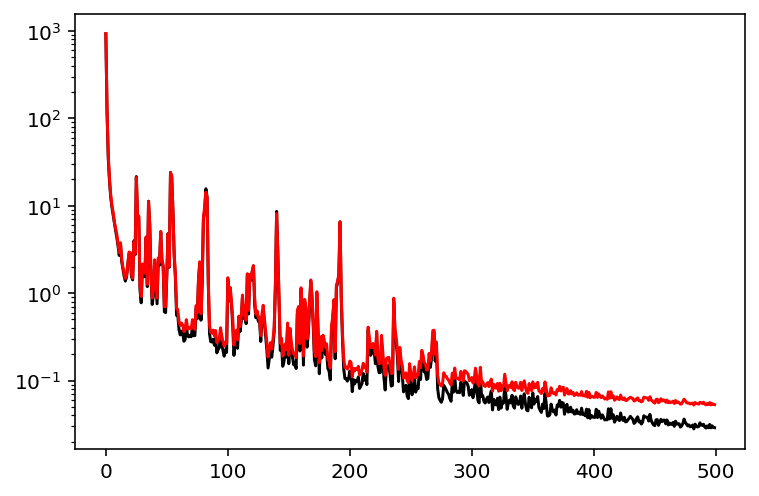

In [56]:
plt.yscale("log")
plt.plot(e_train, color="black")
plt.plot(e_test, color="red");

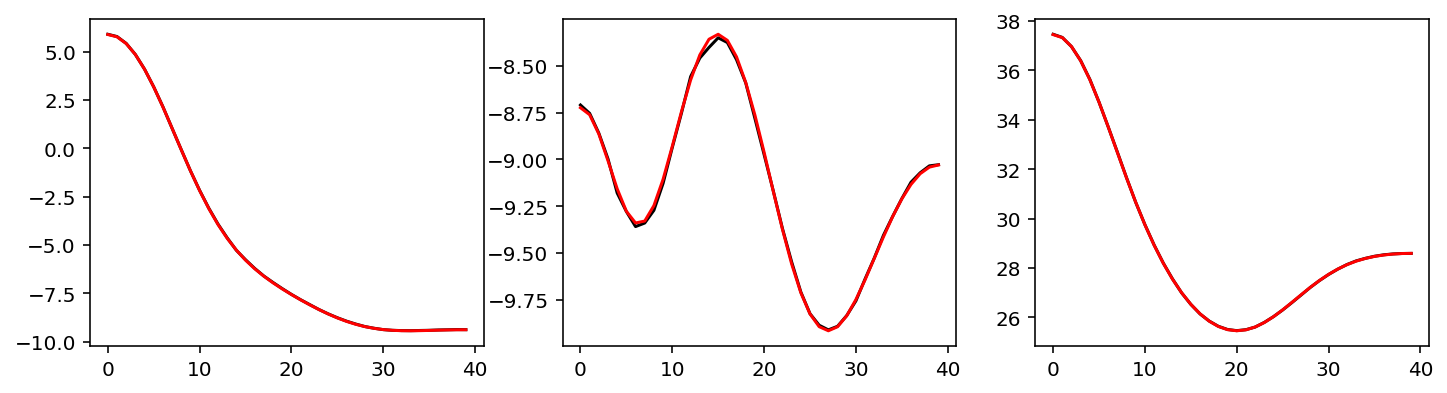

In [57]:
sample = 25
prediction = model2(feature2_train[sample])

fig, ax = plt.subplots(1, 3, figsize=(12, 3))
for k in range(targets2_train[sample].shape[0]):
    ax[k].plot(prediction[k], color="black")
    ax[k].plot(targets2_train[sample][k], color="red");

In [58]:
sample = 25
prediction = model2(feature2_train[sample])

Errors_RK4 = [jnp.linalg.norm(feature2_train[sample].reshape(3, 3, -1)[1, k, :] - targets2_train[sample][k]) for k in range(3)]
Errors_NO = [jnp.linalg.norm(prediction[k, :] - targets2_train[sample][k]) for k in range(3)]

print([e.item() for e in Errors_RK4])
print([e.item() for e in Errors_NO])

[0.0001940100963974609, 0.0002788058601150325, 0.0003893241841160863]
[0.07526760267387436, 0.08351431580541702, 0.04718944146154877]


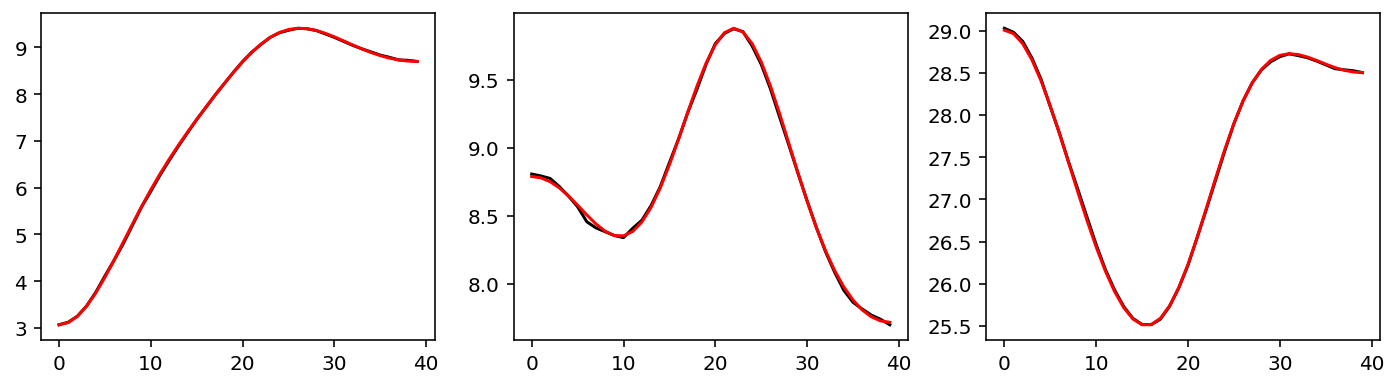

In [59]:
sample = 25
prediction = model2(feature2_test[sample])

fig, ax = plt.subplots(1, 3, figsize=(12, 3))
for k in range(targets2_test[sample].shape[0]):
    ax[k].plot(prediction[k], color="black")
    ax[k].plot(targets2_test[sample][k], color="red");

### With truncation

In [60]:
key = random.PRNGKey(23)

N_features = [feature2_train.shape[1], 64, targets2_train.shape[1]]
N_layers = 5
kernel_size = 5
N_conv = 3
N_modes = 10
model2 = ChebNO.ChebNO(N_features, N_layers, kernel_size, N_conv, N_modes, key)

In [61]:
learning_rate = 1e-3
weight_decay = 1e-2
N_batch = 40
N_epoch_decay = 70
N_epoch = 500
sc = optax.exponential_decay(learning_rate, int(feature2_train.shape[0] / N_batch) * N_epoch_decay, 0.5)
optim = optax.adamw(sc, weight_decay=weight_decay)

opt_state = optim.init(eqx.filter(model2, eqx.is_array))

In [62]:
ChebNO.make_step(model2, feature2_train[:N_batch], targets2_train[:N_batch], optim, opt_state);

In [63]:
%timeit ChebNO.make_step(model2, feature2_train[:N_batch], targets2_train[:N_batch], optim, opt_state);

12.7 ms ± 357 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [64]:
22 * 1e-3 * (feature2_train.shape[0] / N_batch) * N_epoch / 60

7.333333333333332

In [65]:
%timeit ChebNO.compute_loss(model2, feature2_train, targets2_train);

130 ms ± 3.13 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [66]:
e_train = []
e_test = []

key = random.PRNGKey(11)
for i in range(N_epoch):
    key = random.split(key)[0]
    ds = batch_generator([feature2_train, targets2_train], key, N_batch)
    for feature, target in ds:
        loss, model2, opt_state = ChebNO.make_step(model2, feature, target, optim, opt_state)
    e_train.append(ChebNO.compute_loss(model2, feature2_train, targets2_train).item())
    e_test.append(ChebNO.compute_loss(model2, feature2_test, targets2_test).item())

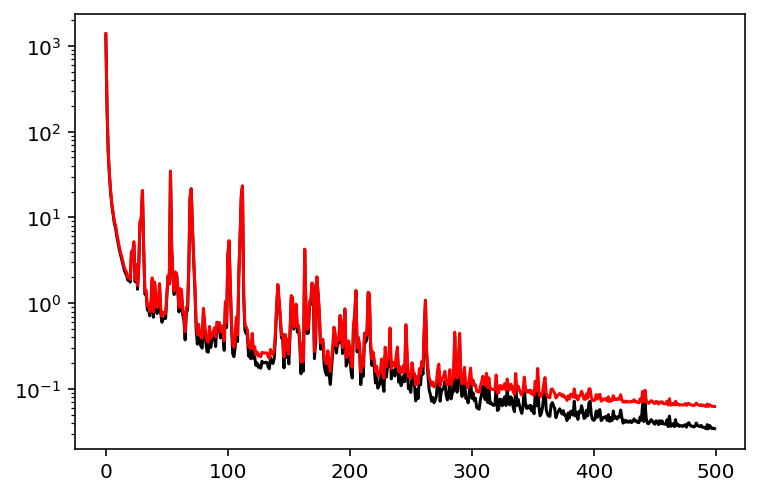

In [67]:
plt.yscale("log")
plt.plot(e_train, color="black")
plt.plot(e_test, color="red");

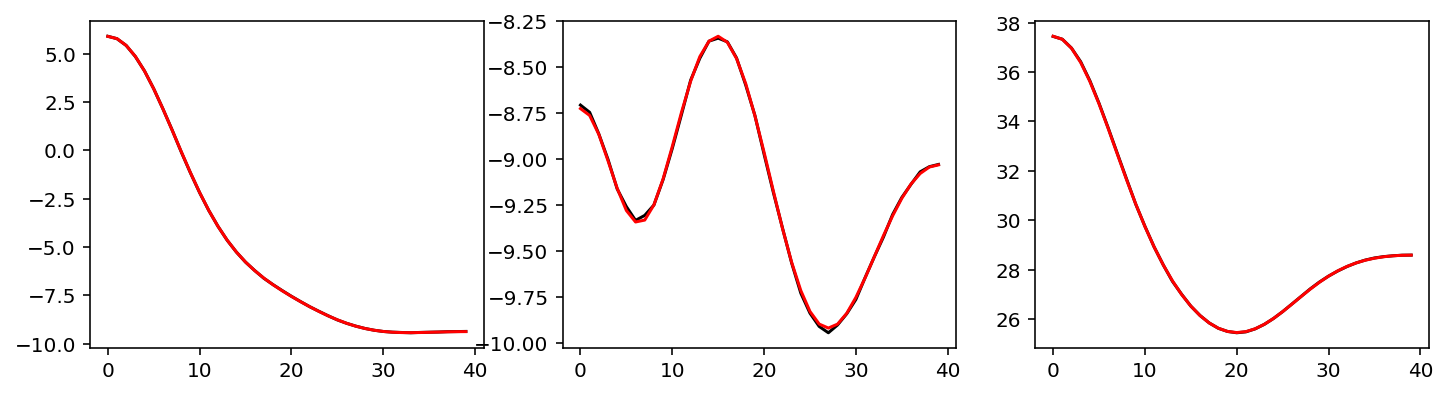

In [68]:
sample = 25
prediction = model2(feature2_train[sample])

fig, ax = plt.subplots(1, 3, figsize=(12, 3))
for k in range(targets2_train[sample].shape[0]):
    ax[k].plot(prediction[k], color="black")
    ax[k].plot(targets2_train[sample][k], color="red");

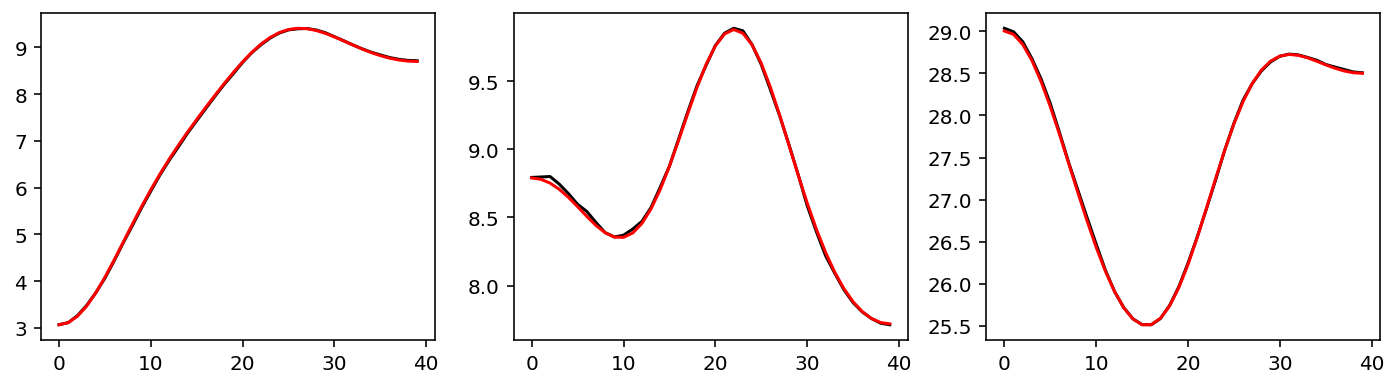

In [69]:
sample = 25
prediction = model2(feature2_test[sample])

fig, ax = plt.subplots(1, 3, figsize=(12, 3))
for k in range(targets2_test[sample].shape[0]):
    ax[k].plot(prediction[k], color="black")
    ax[k].plot(targets2_test[sample][k], color="red");

### With truncation and spatial convolutions

In [70]:
key = random.PRNGKey(23)

N_features = [feature2_train.shape[1], 64, targets2_train.shape[1]]
N_layers = 5
kernel_size = 5
N_conv = 3
N_modes = 10
spatial_kernel_size = 5
model2 = ChebNO.ChebNO(N_features, N_layers, kernel_size, N_conv, N_modes, key, spatial_kernel_size=spatial_kernel_size)

In [71]:
learning_rate = 1e-3
weight_decay = 1e-2
N_batch = 40
N_epoch_decay = 70
N_epoch = 500
sc = optax.exponential_decay(learning_rate, int(feature2_train.shape[0] / N_batch) * N_epoch_decay, 0.5)
optim = optax.adamw(sc, weight_decay=weight_decay)

opt_state = optim.init(eqx.filter(model2, eqx.is_array))

In [72]:
ChebNO.make_step(model2, feature2_train[:N_batch], targets2_train[:N_batch], optim, opt_state);

In [73]:
%timeit ChebNO.make_step(model2, feature2_train[:N_batch], targets2_train[:N_batch], optim, opt_state);

15.7 ms ± 546 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [74]:
22 * 1e-3 * (feature2_train.shape[0] / N_batch) * N_epoch / 60

7.333333333333332

In [75]:
%timeit ChebNO.compute_loss(model2, feature2_train, targets2_train);

154 ms ± 350 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [76]:
e_train = []
e_test = []

key = random.PRNGKey(11)
for i in range(N_epoch):
    key = random.split(key)[0]
    ds = batch_generator([feature2_train, targets2_train], key, N_batch)
    for feature, target in ds:
        loss, model2, opt_state = ChebNO.make_step(model2, feature, target, optim, opt_state)
    e_train.append(ChebNO.compute_loss(model2, feature2_train, targets2_train).item())
    e_test.append(ChebNO.compute_loss(model2, feature2_test, targets2_test).item())

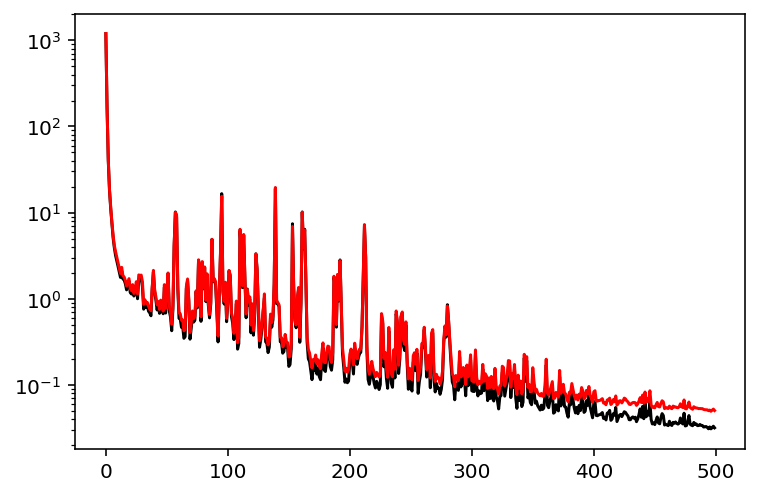

In [77]:
plt.yscale("log")
plt.plot(e_train, color="black")
plt.plot(e_test, color="red");

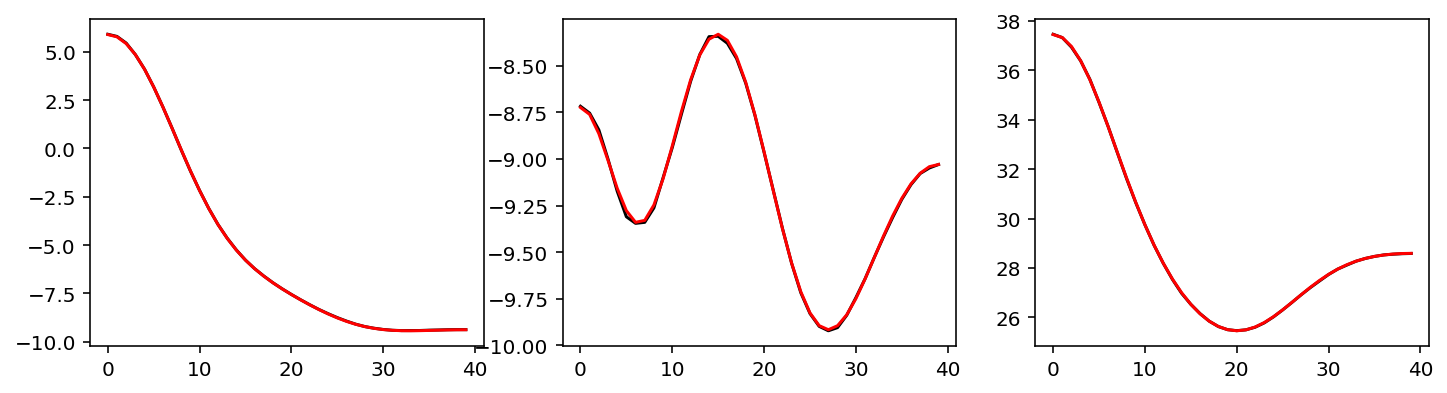

In [78]:
sample = 25
prediction = model2(feature2_train[sample])

fig, ax = plt.subplots(1, 3, figsize=(12, 3))
for k in range(targets2_train[sample].shape[0]):
    ax[k].plot(prediction[k], color="black")
    ax[k].plot(targets2_train[sample][k], color="red");

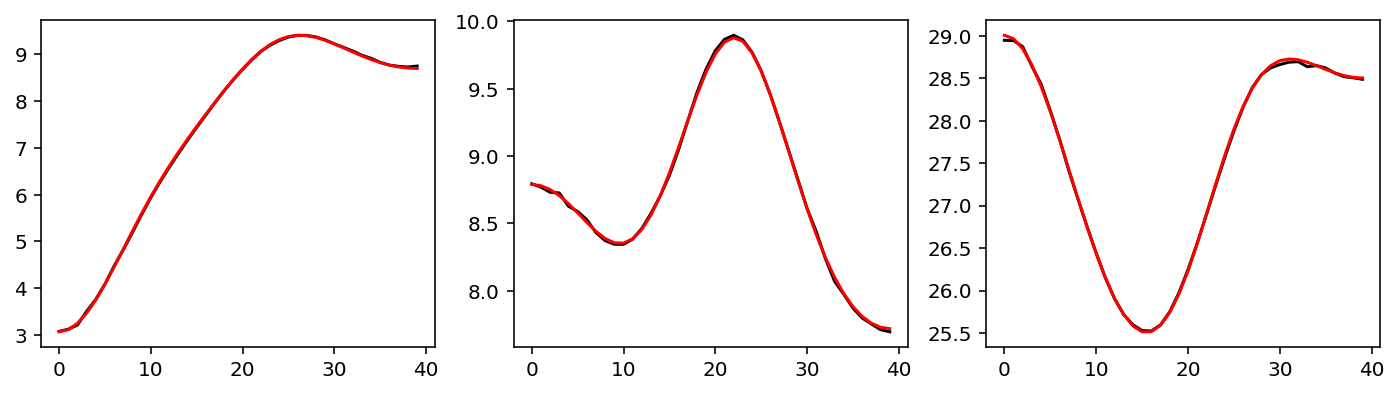

In [79]:
sample = 25
prediction = model2(feature2_test[sample])

fig, ax = plt.subplots(1, 3, figsize=(12, 3))
for k in range(targets2_test[sample].shape[0]):
    ax[k].plot(prediction[k], color="black")
    ax[k].plot(targets2_test[sample][k], color="red");

# Evaluate and compare models

In [80]:
def apply_model(features, t0, t1, model):
    return model(features)

def get_features(dataset_t, model_output, features_type, n):
    return dataset_t[:n, :, :].reshape(9, -1)

def apply_SDC(features, t0, t1, N_SDC):
    solver = RK4.integrator
    corrector = RK4_c.deferred_correction
    values = solver(features, ODE_data["F"], N_points, t0, t1)
    for i in range(N_SDC-2):
        values = corrector(values, ODE_data["F"], t0, t1)
    return values

def get_features_SDC(dataset_t, model_output, features_type):
    return dataset_t[-1, :, 0]

def get_features_RK4(dataset_t, model_output, features_type):
    return dataset_t[1, :, :]

In [81]:
apply_model_ = lambda a, b, c: apply_model(a, b, c, model2)
get_features_ = lambda a, b, c: get_features(a, b, c, 3)

train_errors_one_shot = metrics.relative_error(apply_model_, get_features_, dataset[:800], T)
mean_train_errors_one_shot = metrics.mean_relative_error(train_errors_one_shot)

test_errors_one_shot = metrics.relative_error(apply_model_, get_features_, dataset[800:], T)
mean_test_errors_one_shot = metrics.mean_relative_error(test_errors_one_shot)

train_errors_one_shot_SDC = metrics.relative_error(lambda a, b, c: apply_SDC(a, b, c, 1), get_features_SDC, dataset[:800], T)
mean_train_errors_one_shot_SDC = metrics.mean_relative_error(train_errors_one_shot_SDC)

test_errors_one_shot_SDC = metrics.relative_error(lambda a, b, c: apply_SDC(a, b, c, 1), get_features_SDC, dataset[800:], T)
mean_test_errors_one_shot_SDC = metrics.mean_relative_error(test_errors_one_shot_SDC)

train_errors_one_shot_RK4 = metrics.relative_error(lambda x, a, b: x, get_features_RK4, dataset[:800], T)
mean_train_errors_one_shot_RK4 = metrics.mean_relative_error(train_errors_one_shot_RK4)

test_errors_one_shot_RK4 = metrics.relative_error(lambda x, a, b: x, get_features_RK4, dataset[800:], T)
mean_test_errors_one_shot_RK4 = metrics.mean_relative_error(test_errors_one_shot_RK4)

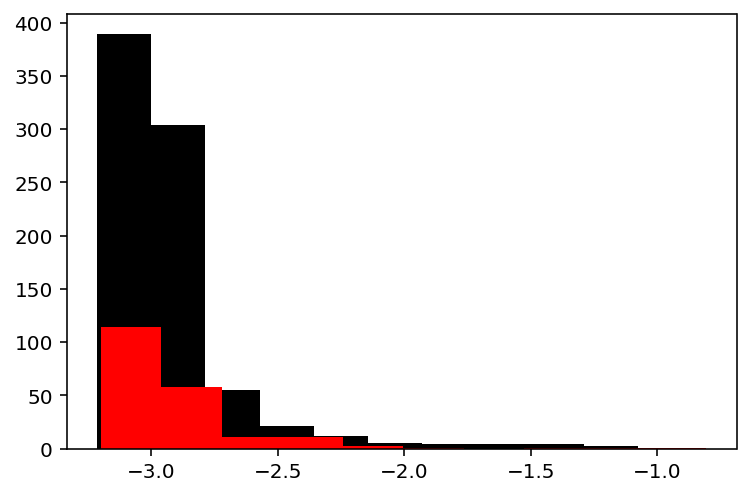

In [82]:
plt.hist(jnp.log10(mean_train_errors_one_shot), color="black")
plt.hist(jnp.log10(mean_test_errors_one_shot), color="red");

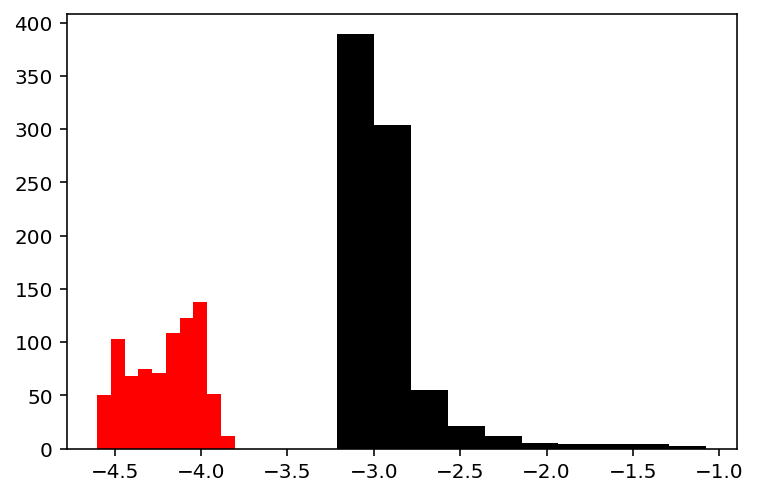

In [83]:
plt.hist(jnp.log10(mean_train_errors_one_shot), color="black")
plt.hist(jnp.log10(mean_train_errors_one_shot_RK4), color="red");